# Reproduce Paper Results
## An Attention-Based U-Net for Detecting Deforestation Within Satellite Sensor Imagery

**Paper Reference:** https://www.sciencedirect.com/science/article/pii/S0303243422000113

This notebook reproduces the key experiments from the paper, including:
- Data loading and preprocessing
- Model architectures (U-Net, Attention U-Net, FCN32-VGG16, ResNet50-SegNet)
- Training with data augmentation
- Evaluation on test sets with accuracy, precision, recall, and F1-score metrics

### Expected Results (from paper):
| Model | Accuracy | Precision | Recall | F1-Score |
|-------|----------|-----------|--------|----------|
| Attention U-Net | 0.9748 | 0.9758 | 0.9748 | 0.9753 |
| U-Net | 0.9724 | 0.9738 | 0.9724 | 0.9731 |
| ResNet50-SegNet | 0.9694 | 0.9707 | 0.9694 | 0.9701 |
| FCN32-VGG16 | 0.9205 | 0.9212 | 0.9205 | 0.9208 |

# 1. Import Required Libraries

In [ ]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

PyTorch version: 2.10.0.dev20251124+cu128
Device: cuda
GPU: NVIDIA GeForce RTX 5070
GPU Memory: 11.9 GB


# 2. Download and Prepare Dataset

The paper uses two datasets:
1. **Amazon Forest Dataset (RGB)** - 3-band satellite imagery from Zenodo
2. **4-band Amazon/Atlantic Forest Dataset** - 4-band Sentinel-2 imagery

For this reproduction, we'll use the preprocessed 4-band Amazon dataset which has already been prepared as numpy arrays.

In [ ]:
# Configuration
BASE_DIR = "..\\deforestation-adaptation\\"  # Change if needed
AMAZON_4BAND_DIR = os.path.join(BASE_DIR, "amazon-processed-large")
ATLANTIC_4BAND_DIR = os.path.join(BASE_DIR, "atlantic-processed-large")
MODELS_DIR = os.path.join(BASE_DIR, "models")

# Check for existing data
print("Checking for preprocessed data...")
for dataset_name, dataset_dir in [("Amazon 4-band", AMAZON_4BAND_DIR), 
                                   ("Atlantic 4-band", ATLANTIC_4BAND_DIR)]:
    if os.path.exists(dataset_dir):
        splits = ['training', 'validation', 'test']
        for split in splits:
            images_dir = os.path.join(dataset_dir, split, 'images')
            if os.path.exists(images_dir):
                n_files = len([f for f in os.listdir(images_dir) if f.endswith('.npy')])
                print(f"  {dataset_name} {split}: {n_files} images")
    else:
        print(f"  {dataset_name}: NOT FOUND - run preprocessing script first")

print("\nChecking for pre-trained models...")
if os.path.exists(MODELS_DIR):
    for model_file in os.listdir(MODELS_DIR):
        print(f"  Found: {model_file}")

Checking for preprocessed data...
  Amazon 4-band: NOT FOUND - run preprocessing script first
  Atlantic 4-band: NOT FOUND - run preprocessing script first

Checking for pre-trained models...
  Found: unet-attention-3d.hdf5
  Found: unet-attention-4d-atlantic.hdf5
  Found: unet-attention-4d.hdf5


In [34]:
def load_4band_dataset_numpy(base_dir, split='training'):
    """Load preprocessed 4-band dataset from numpy files"""
    images_dir = os.path.join(base_dir, split, 'images')
    masks_dir = os.path.join(base_dir, split, 'masks')
    
    images = []
    masks = []
    
    if not os.path.exists(images_dir):
        print(f"Warning: {images_dir} not found")
        return images, masks
    
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.npy')])
    
    for f in image_files:
        img = np.load(os.path.join(images_dir, f))
        images.append(img)
        
        mask_file = os.path.join(masks_dir, f)
        if os.path.exists(mask_file):
            mask = np.load(mask_file)
            masks.append(mask)
    
    return images, masks

# Load 4-band Amazon dataset
print("Loading 4-band Amazon dataset...")
train_images, train_masks = load_4band_dataset_numpy(AMAZON_4BAND_DIR, 'training')
val_images, val_masks = load_4band_dataset_numpy(AMAZON_4BAND_DIR, 'validation')
test_images, test_masks = load_4band_dataset_numpy(AMAZON_4BAND_DIR, 'test')

print(f"\nDataset loaded:")
print(f"  Training:   {len(train_images)} images, {len(train_masks)} masks")
print(f"  Validation: {len(val_images)} images, {len(val_masks)} masks")
print(f"  Test:       {len(test_images)} images, {len(test_masks)} masks")

Loading 4-band Amazon dataset...

Dataset loaded:
  Training:   250 images, 250 masks
  Validation: 100 images, 100 masks
  Test:       20 images, 20 masks

Dataset loaded:
  Training:   250 images, 250 masks
  Validation: 100 images, 100 masks
  Test:       20 images, 20 masks


# 3. Data Preprocessing and Augmentation

The paper uses extensive data augmentation including:
- Rotation (0-180°)
- Width/height shifts (25%)
- Shear transformation (25%)
- Zoom (25%)
- Horizontal and vertical flips

In [35]:
# PyTorch Dataset class
class DeforestationDataset(Dataset):
    """Dataset for deforestation segmentation"""
    def __init__(self, images, masks, augment=False):
        self.images = images
        self.masks = masks
        self.augment = augment
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get image and mask
        image = self.images[idx].reshape(512, 512, 4).astype(np.float32)
        mask = self.masks[idx].reshape(512, 512, 1).astype(np.float32)
        
        # Normalize image
        if image.max() > 1:
            image = image / image.max()
        
        # Data augmentation
        if self.augment:
            # Random horizontal flip
            if np.random.random() > 0.5:
                image = np.flip(image, axis=1).copy()
                mask = np.flip(mask, axis=1).copy()
            # Random vertical flip
            if np.random.random() > 0.5:
                image = np.flip(image, axis=0).copy()
                mask = np.flip(mask, axis=0).copy()
            # Random 90 degree rotation
            k = np.random.randint(0, 4)
            image = np.rot90(image, k, axes=(0, 1)).copy()
            mask = np.rot90(mask, k, axes=(0, 1)).copy()
        
        # Convert to PyTorch tensors (C, H, W format)
        image = torch.from_numpy(image).permute(2, 0, 1)  # (4, 512, 512)
        mask = torch.from_numpy(mask).permute(2, 0, 1)    # (1, 512, 512)
        
        return image, mask

# Prepare datasets
if len(train_images) > 0:
    train_dataset = DeforestationDataset(train_images, train_masks, augment=True)
    val_dataset = DeforestationDataset(val_images, val_masks, augment=False)
    test_dataset = DeforestationDataset(test_images, test_masks, augment=False)
    
    # Create DataLoaders
    BATCH_SIZE = 4  # Can use larger batch with GPU
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
    
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation samples: {len(val_loader)}")
    print(f"Test samples: {len(test_loader)}")
    print(f"Batch size: {BATCH_SIZE}")
else:
    print("No training data found!")

Training batches: 63
Validation samples: 100
Test samples: 20
Batch size: 4


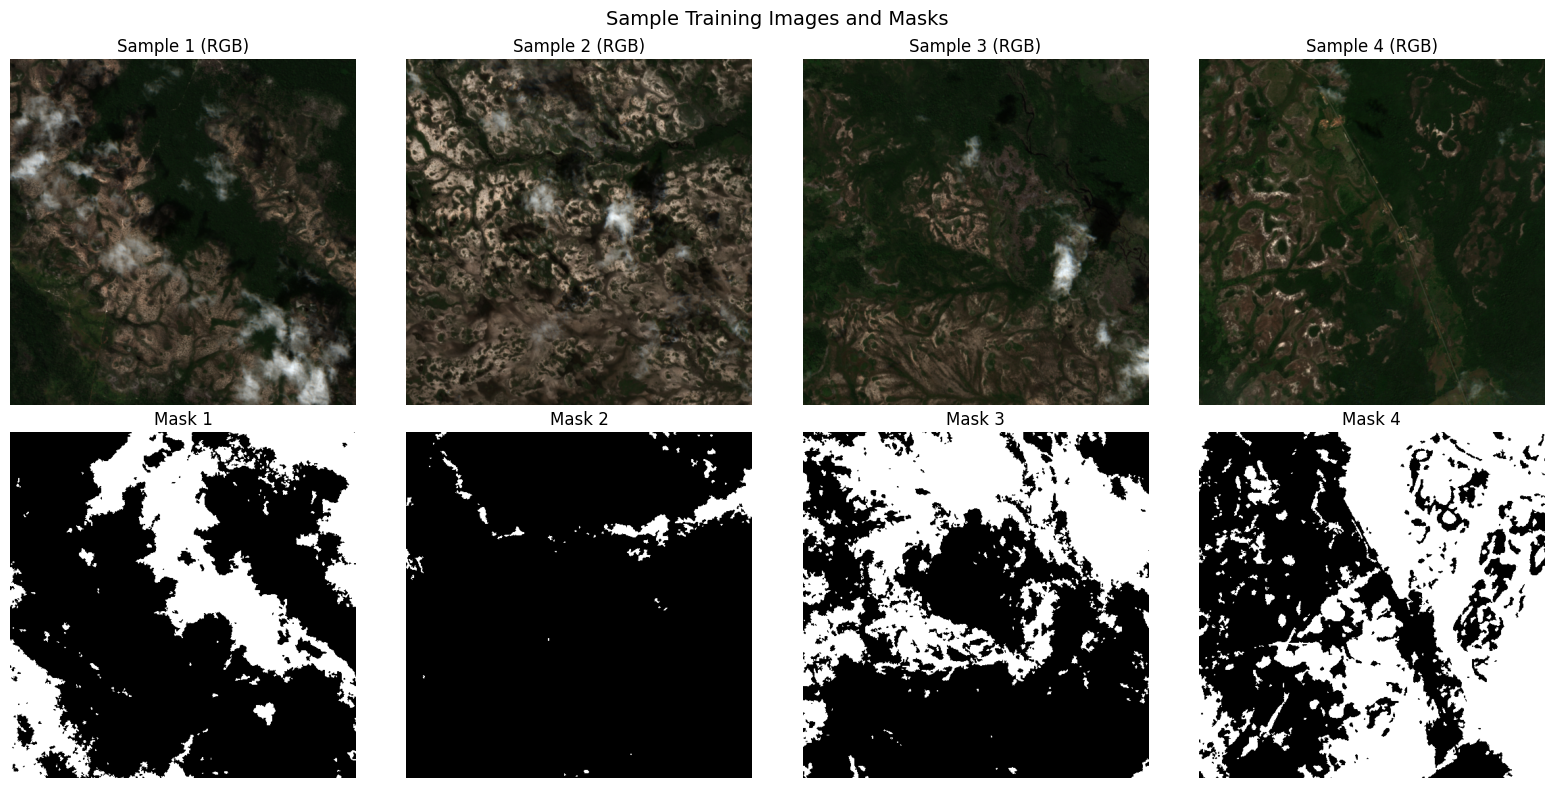

In [36]:
# Visualize sample data from DataLoader
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Get a batch of samples
sample_batch = next(iter(train_loader))
images, masks = sample_batch

for i in range(min(4, len(images))):
    img = images[i].numpy()
    mask = masks[i].numpy()
    
    # Show RGB bands (first 3 channels) - CHW -> HWC
    rgb = np.transpose(img[:3], (1, 2, 0))
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalize for display
    axes[0, i].imshow(rgb)
    axes[0, i].set_title(f'Sample {i+1} (RGB)')
    axes[0, i].axis('off')
    
    # Show mask
    axes[1, i].imshow(mask.squeeze(), cmap='gray')
    axes[1, i].set_title(f'Mask {i+1}')
    axes[1, i].axis('off')

plt.suptitle('Sample Training Images and Masks', fontsize=14)
plt.tight_layout()
plt.show()

# 4. Build Standard U-Net Architecture

The baseline U-Net architecture follows the original design by Ronneberger et al. (2015), with:
- Encoder path: 4 downsampling blocks with 64→128→256→512→1024 filters
- Decoder path: 4 upsampling blocks with skip connections
- Binary output with sigmoid activation

In [37]:
class ConvBlock(nn.Module):
    """Double convolution block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """Standard U-Net architecture in PyTorch"""
    def __init__(self, in_channels=4, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        
        # Encoder
        for feature in features:
            self.downs.append(ConvBlock(in_channels, feature))
            in_channels = feature
        
        # Bottleneck
        self.bottleneck = ConvBlock(features[-1], features[-1] * 2)
        
        # Decoder
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, 2, 2))
            self.ups.append(ConvBlock(feature * 2, feature))
        
        # Output
        self.output = nn.Conv2d(features[0], out_channels, 1)
    
    def forward(self, x):
        skip_connections = []
        
        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        # Decoder
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx // 2]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = self.ups[idx + 1](x)
        
        return torch.sigmoid(self.output(x))

# Test U-Net
unet = UNet(in_channels=4).to(device)
total_params = sum(p.numel() for p in unet.parameters())
print(f"U-Net parameters: {total_params:,}")

U-Net parameters: 31,044,097


# 5. Implement Attention Gate Module

The attention gate mechanism learns to focus on relevant spatial features. It takes:
- `x`: Feature map from the encoder (skip connection)
- `gating`: Signal from the decoder path

The attention coefficient α is computed as:
$$\alpha = \sigma(W_\psi \cdot \text{ReLU}(W_x \cdot x + W_g \cdot g))$$

In [38]:
class AttentionGate(nn.Module):
    """
    Attention Gate mechanism for Attention U-Net
    
    Based on: "Attention U-Net: Learning Where to Look for the Pancreas" (Oktay et al., 2018)
    """
    def __init__(self, F_g, F_l, F_int):
        """
        Args:
            F_g: Number of channels in gating signal
            F_l: Number of channels in skip connection (encoder feature)
            F_int: Number of intermediate channels
        """
        super().__init__()
        
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, 1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, 1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, 1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        """
        Args:
            g: Gating signal from decoder (lower resolution)
            x: Skip connection from encoder (higher resolution)
        """
        # Upsample gating signal to match skip connection size
        g1 = self.W_g(g)
        g1 = F.interpolate(g1, size=x.shape[2:], mode='bilinear', align_corners=True)
        
        x1 = self.W_x(x)
        
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        return x * psi

print("Attention Gate module defined!")

Attention Gate module defined!


# 6. Build Attention U-Net Architecture

The Attention U-Net integrates attention gates into the skip connections, allowing the model to focus on relevant regions for deforestation detection.

In [39]:
class AttentionUNet(nn.Module):
    """
    Attention U-Net - THE MAIN MODEL FROM THE PAPER
    
    Combines U-Net architecture with attention gates for improved 
    deforestation detection in satellite imagery.
    """
    def __init__(self, in_channels=4, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Encoder
        self.encoder1 = ConvBlock(in_channels, features[0])
        self.encoder2 = ConvBlock(features[0], features[1])
        self.encoder3 = ConvBlock(features[1], features[2])
        self.encoder4 = ConvBlock(features[2], features[3])
        
        # Bottleneck
        self.bottleneck = ConvBlock(features[3], features[3] * 2)
        
        # Decoder with Attention Gates
        self.upconv4 = nn.ConvTranspose2d(features[3] * 2, features[3], 2, 2)
        self.att4 = AttentionGate(F_g=features[3], F_l=features[3], F_int=features[3] // 2)
        self.decoder4 = ConvBlock(features[3] * 2, features[3])
        
        self.upconv3 = nn.ConvTranspose2d(features[3], features[2], 2, 2)
        self.att3 = AttentionGate(F_g=features[2], F_l=features[2], F_int=features[2] // 2)
        self.decoder3 = ConvBlock(features[2] * 2, features[2])
        
        self.upconv2 = nn.ConvTranspose2d(features[2], features[1], 2, 2)
        self.att2 = AttentionGate(F_g=features[1], F_l=features[1], F_int=features[1] // 2)
        self.decoder2 = ConvBlock(features[1] * 2, features[1])
        
        self.upconv1 = nn.ConvTranspose2d(features[1], features[0], 2, 2)
        self.att1 = AttentionGate(F_g=features[0], F_l=features[0], F_int=features[0] // 2)
        self.decoder1 = ConvBlock(features[0] * 2, features[0])
        
        # Output
        self.output = nn.Conv2d(features[0], out_channels, 1)
    
    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder with Attention
        d4 = self.upconv4(b)
        e4_att = self.att4(d4, e4)
        d4 = self.decoder4(torch.cat([e4_att, d4], dim=1))
        
        d3 = self.upconv3(d4)
        e3_att = self.att3(d3, e3)
        d3 = self.decoder3(torch.cat([e3_att, d3], dim=1))
        
        d2 = self.upconv2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.decoder2(torch.cat([e2_att, d2], dim=1))
        
        d1 = self.upconv1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.decoder1(torch.cat([e1_att, d1], dim=1))
        
        return torch.sigmoid(self.output(d1))

# Create model and move to GPU
model = AttentionUNet(in_channels=4).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Attention U-Net parameters: {total_params:,}")
print(f"Model device: {next(model.parameters()).device}")

Attention U-Net parameters: 31,395,629
Model device: cuda:0


# 7. Define Loss Functions and Metrics

The paper uses:
- **Loss**: Binary cross-entropy
- **Metrics**: Accuracy, Precision, Recall, F1-Score

In [40]:
def evaluate_pytorch_model(model, dataloader, device):
    """
    Evaluate a PyTorch model on a dataset.
    Returns accuracy, precision, recall, and F1-score.
    
    Note: Uses 'binary' average for precision/recall/F1 which calculates
    metrics for the positive class (class 1 = deforestation).
    Uses sklearn's f1_score directly instead of manual calculation.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float().cpu().numpy().flatten()
            labels = masks.numpy().flatten()
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics properly for binary segmentation
    # Use 'binary' to get metrics for the positive class (deforestation)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def dice_loss(pred, target, smooth=1e-5):
    """Dice loss for segmentation"""
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def combined_loss(pred, target):
    """Combined BCE and Dice loss"""
    bce = F.binary_cross_entropy(pred, target)
    dice = dice_loss(pred, target)
    return bce + dice

print("Evaluation and loss functions defined successfully!")

Evaluation and loss functions defined successfully!


# 8. Train the Models

Training configuration from the paper:
- **Optimizer**: Adam
- **Learning rate**: 0.0005 for Attention U-Net, 0.0001 for others
- **Epochs**: 50
- **Steps per epoch**: 100
- **Batch size**: 1

In [41]:
# Training configuration
EPOCHS = 50
LEARNING_RATE = 0.0005  # From paper for Attention U-Net
TRAIN_FROM_SCRATCH = True
QUICK_TRAIN = False  # Set to False for full paper reproduction
EPOCHS_QUICK = 10

print(f"Training Configuration:")
print(f"  Device: {device}")
print(f"  Epochs: {EPOCHS_QUICK if QUICK_TRAIN else EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")

Training Configuration:
  Device: cuda
  Epochs: 50
  Learning Rate: 0.0005
  Batch Size: 4
  Training samples: 250
  Validation samples: 100


In [ ]:
def train_model(model, train_loader, val_loader, epochs, lr, device, save_path=None):
    """
    PyTorch training loop with GPU support.
    """
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    # Default save path
    if save_path is None:
        save_path = os.path.join(MODELS_DIR, 'attention_unet_best.pth')
    
    # Ensure the models directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = (outputs > 0.5).float()
            train_correct += (preds == masks).sum().item()
            train_total += masks.numel()
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = combined_loss(outputs, masks)
                
                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_correct += (preds == masks).sum().item()
                val_total += masks.numel()
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        # Update scheduler
        scheduler.step(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"  ✓ New best model saved to: {save_path}")
        
        # Record history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return history

# Train the model
if TRAIN_FROM_SCRATCH:
    print("\n" + "="*60)
    print(f"Training Attention U-Net on {device}")
    print("="*60)
    
    epochs = EPOCHS_QUICK if QUICK_TRAIN else EPOCHS
    save_path = os.path.join(MODELS_DIR, 'attention_unet_best.pth')
    history = train_model(model, train_loader, val_loader, epochs, LEARNING_RATE, device, save_path)
    
    print("\n✓ Training complete!")
    print(f"Model saved to: {save_path}")


Training Attention U-Net on cuda


Epoch 1/50: 100%|██████████| 63/63 [01:09<00:00,  1.11s/it, loss=0.3976]



  ✓ New best model saved!
  Train Loss: 0.5020, Train Acc: 0.8796
  Val Loss: 0.4470, Val Acc: 0.9276


Epoch 2/50: 100%|██████████| 63/63 [01:09<00:00,  1.11s/it, loss=0.5761]



  ✓ New best model saved!
  Train Loss: 0.3459, Train Acc: 0.9239
  Val Loss: 0.2638, Val Acc: 0.9526


Epoch 3/50: 100%|██████████| 63/63 [01:09<00:00,  1.11s/it, loss=0.3476]



  Train Loss: 0.3233, Train Acc: 0.9270
  Val Loss: 0.5308, Val Acc: 0.9040


Epoch 4/50: 100%|██████████| 63/63 [01:10<00:00,  1.11s/it, loss=0.5291]



  ✓ New best model saved!
  Train Loss: 0.2824, Train Acc: 0.9343
  Val Loss: 0.2339, Val Acc: 0.9591


Epoch 5/50: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it, loss=0.1171]



  ✓ New best model saved!
  Train Loss: 0.2593, Train Acc: 0.9390
  Val Loss: 0.2255, Val Acc: 0.9608


Epoch 6/50: 100%|██████████| 63/63 [01:09<00:00,  1.11s/it, loss=0.1657]



  ✓ New best model saved!
  Train Loss: 0.2122, Train Acc: 0.9501
  Val Loss: 0.1841, Val Acc: 0.9627


Epoch 7/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.3378]



  Train Loss: 0.2251, Train Acc: 0.9450
  Val Loss: 0.1951, Val Acc: 0.9602


Epoch 8/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1922]



  Train Loss: 0.2066, Train Acc: 0.9490
  Val Loss: 0.2819, Val Acc: 0.9439


Epoch 9/50: 100%|██████████| 63/63 [01:09<00:00,  1.11s/it, loss=0.1211]



  Train Loss: 0.2382, Train Acc: 0.9409
  Val Loss: 0.3917, Val Acc: 0.9314


Epoch 10/50: 100%|██████████| 63/63 [01:09<00:00,  1.11s/it, loss=0.1811]



  Train Loss: 0.2082, Train Acc: 0.9494
  Val Loss: 0.2148, Val Acc: 0.9633


Epoch 11/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1987]



  Train Loss: 0.1986, Train Acc: 0.9501
  Val Loss: 0.2531, Val Acc: 0.9553


Epoch 12/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.2754]



  ✓ New best model saved!
  Train Loss: 0.1814, Train Acc: 0.9552
  Val Loss: 0.1687, Val Acc: 0.9650


Epoch 13/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1385]



  Train Loss: 0.1953, Train Acc: 0.9515
  Val Loss: 0.2211, Val Acc: 0.9653


Epoch 14/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.2303]



  Train Loss: 0.1730, Train Acc: 0.9547
  Val Loss: 0.1702, Val Acc: 0.9671


Epoch 15/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1890]



  Train Loss: 0.1724, Train Acc: 0.9565
  Val Loss: 0.1832, Val Acc: 0.9657


Epoch 16/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.0831]



  Train Loss: 0.1758, Train Acc: 0.9541
  Val Loss: 0.1971, Val Acc: 0.9635


Epoch 17/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1207]



  Train Loss: 0.1702, Train Acc: 0.9579
  Val Loss: 0.1732, Val Acc: 0.9658


Epoch 18/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1472]



  Train Loss: 0.1839, Train Acc: 0.9530
  Val Loss: 0.1852, Val Acc: 0.9669


Epoch 19/50: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it, loss=0.1016]



  Train Loss: 0.1567, Train Acc: 0.9604
  Val Loss: 0.1745, Val Acc: 0.9671


Epoch 20/50: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it, loss=0.0970]



  Train Loss: 0.1384, Train Acc: 0.9641
  Val Loss: 0.1769, Val Acc: 0.9662


Epoch 21/50: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it, loss=0.1259]



  Train Loss: 0.1418, Train Acc: 0.9636
  Val Loss: 0.2543, Val Acc: 0.9539


Epoch 22/50: 100%|██████████| 63/63 [01:08<00:00,  1.10s/it, loss=0.2969]



  Train Loss: 0.1536, Train Acc: 0.9627
  Val Loss: 0.1707, Val Acc: 0.9666


Epoch 23/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1839]



  ✓ New best model saved!
  Train Loss: 0.1513, Train Acc: 0.9624
  Val Loss: 0.1625, Val Acc: 0.9681


Epoch 24/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.3438]



  Train Loss: 0.1459, Train Acc: 0.9623
  Val Loss: 0.1888, Val Acc: 0.9637


Epoch 25/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.2160]



  Train Loss: 0.1349, Train Acc: 0.9659
  Val Loss: 0.1891, Val Acc: 0.9641


Epoch 26/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.4981]



  Train Loss: 0.1569, Train Acc: 0.9626
  Val Loss: 0.1865, Val Acc: 0.9646


Epoch 27/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1339]



  ✓ New best model saved!
  Train Loss: 0.1391, Train Acc: 0.9646
  Val Loss: 0.1538, Val Acc: 0.9698


Epoch 28/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.0994]



  Train Loss: 0.1394, Train Acc: 0.9641
  Val Loss: 0.1603, Val Acc: 0.9684


Epoch 29/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.0748]



  Train Loss: 0.1291, Train Acc: 0.9666
  Val Loss: 0.1731, Val Acc: 0.9663


Epoch 30/50: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it, loss=0.0918]



  Train Loss: 0.1306, Train Acc: 0.9667
  Val Loss: 0.1898, Val Acc: 0.9643


Epoch 31/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.3825]



  Train Loss: 0.1471, Train Acc: 0.9623
  Val Loss: 0.2402, Val Acc: 0.9527


Epoch 32/50: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it, loss=0.1783]



  Train Loss: 0.1638, Train Acc: 0.9594
  Val Loss: 0.1606, Val Acc: 0.9703


Epoch 33/50: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it, loss=0.1010]



  Train Loss: 0.1322, Train Acc: 0.9662
  Val Loss: 0.1748, Val Acc: 0.9673


Epoch 34/50: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it, loss=0.2169]



  Train Loss: 0.1303, Train Acc: 0.9671
  Val Loss: 0.1682, Val Acc: 0.9677


Epoch 35/50: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it, loss=0.0658]



  Train Loss: 0.1220, Train Acc: 0.9683
  Val Loss: 0.1588, Val Acc: 0.9694


Epoch 36/50: 100%|██████████| 63/63 [01:08<00:00,  1.10s/it, loss=0.0839]



  Train Loss: 0.1195, Train Acc: 0.9685
  Val Loss: 0.1634, Val Acc: 0.9685


Epoch 37/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1859]



  Train Loss: 0.1195, Train Acc: 0.9691
  Val Loss: 0.1744, Val Acc: 0.9672


Epoch 38/50: 100%|██████████| 63/63 [01:08<00:00,  1.10s/it, loss=0.4174]



  Train Loss: 0.1263, Train Acc: 0.9683
  Val Loss: 0.1566, Val Acc: 0.9704


Epoch 39/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=1.4473]



  ✓ New best model saved!
  Train Loss: 0.1494, Train Acc: 0.9663
  Val Loss: 0.1529, Val Acc: 0.9707


Epoch 40/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1137]



  Train Loss: 0.1241, Train Acc: 0.9682
  Val Loss: 0.1842, Val Acc: 0.9651


Epoch 41/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1088]



  Train Loss: 0.1216, Train Acc: 0.9686
  Val Loss: 0.1703, Val Acc: 0.9678


Epoch 42/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1517]



  Train Loss: 0.1184, Train Acc: 0.9694
  Val Loss: 0.1697, Val Acc: 0.9676


Epoch 43/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.1077]



  Train Loss: 0.1218, Train Acc: 0.9682
  Val Loss: 0.1904, Val Acc: 0.9640


Epoch 44/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.0860]



  Train Loss: 0.1183, Train Acc: 0.9693
  Val Loss: 0.1643, Val Acc: 0.9683


Epoch 45/50: 100%|██████████| 63/63 [01:08<00:00,  1.10s/it, loss=0.2745]



  Train Loss: 0.1256, Train Acc: 0.9688
  Val Loss: 0.1671, Val Acc: 0.9682


Epoch 46/50: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it, loss=0.1111]



  Train Loss: 0.1216, Train Acc: 0.9694
  Val Loss: 0.1735, Val Acc: 0.9680


Epoch 47/50: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it, loss=0.4494]



  ✓ New best model saved!
  Train Loss: 0.1187, Train Acc: 0.9701
  Val Loss: 0.1488, Val Acc: 0.9708


Epoch 48/50: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, loss=0.0734]



  Train Loss: 0.1096, Train Acc: 0.9712
  Val Loss: 0.1612, Val Acc: 0.9696


Epoch 49/50: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it, loss=0.0717]



  Train Loss: 0.1119, Train Acc: 0.9711
  Val Loss: 0.1655, Val Acc: 0.9681


Epoch 50/50: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it, loss=0.1237]



  Train Loss: 0.1330, Train Acc: 0.9690
  Val Loss: 0.1593, Val Acc: 0.9698

✓ Training complete!


# 8.1 Load Pre-trained Model (Skip Training)

If you have already trained the model and saved the weights, you can skip training and load the pre-trained weights directly. This is useful for:
- Quick evaluation without re-training
- Reproducing results with saved model weights
- Testing on different datasets

Available pre-trained models:
- `attention_unet_best.pth` - PyTorch weights from training
- `models/unet-attention-4d.hdf5` - Original Keras/TF weights (Amazon)
- `models/unet-attention-4d-atlantic.hdf5` - Keras/TF weights (Atlantic Forest)

In [ ]:
# ============================================================================
# Check for Pre-trained Model and Decide Training Strategy
# ============================================================================

PRETRAINED_PATH = os.path.join(MODELS_DIR, 'attention_unet_best.pth')
DATASET_PATH = os.path.join(BASE_DIR, 'dataset')

# Check if pre-trained model exists
if os.path.exists(PRETRAINED_PATH):
    print(f"✓ Pre-trained model found at: {PRETRAINED_PATH}")
    print("Loading pre-trained model (skipping training)...")
    
    # Re-create model architecture
    model = AttentionUNet(in_channels=4).to(device)
    
    # Load weights
    model.load_state_dict(torch.load(PRETRAINED_PATH, map_location=device, weights_only=True))
    model.eval()
    
    print(f"✓ Pre-trained model loaded successfully!")
    print(f"  Model device: {device}")
    print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Create empty history for compatibility with plotting cells
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    print("\nNote: Training history is empty since model was loaded from checkpoint.")
    print("Skip the training history plots if they show empty graphs.")
    
    TRAIN_FROM_SCRATCH = False
else:
    print(f"⚠ Pre-trained model NOT available at: {PRETRAINED_PATH}")
    print("\n" + "="*60)
    print("MODEL WILL BE TRAINED FROM SCRATCH")
    print("="*60)
    print(f"\n⚠ IMPORTANT: Ensure the dataset is downloaded and saved to:")
    print(f"   {DATASET_PATH}")
    print("\nExpected dataset structure:")
    print("   deforestation-adaptation/dataset/")
    print("   ├── training/")
    print("   │   ├── images/")
    print("   │   └── masks/")
    print("   ├── validation/")
    print("   │   ├── images/")
    print("   │   └── masks/")
    print("   └── test/")
    print("       ├── images/")
    print("       └── masks/")
    print("\nProceeding with training...")
    
    TRAIN_FROM_SCRATCH = True

USE_PRETRAINED = False
Model will be trained using the training cell above.


# 9. Evaluate Model Performance

Compare trained models with the paper's reported results.

In [ ]:
# Evaluate on test set
print("Evaluating on test set...")

# Load best model weights from the correct path
model_path = os.path.join(MODELS_DIR, 'attention_unet_best.pth')
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))

# Evaluate
test_metrics = evaluate_pytorch_model(model, test_loader, device)

print(f"\n{'='*60}")
print("Attention U-Net Test Results:")
print(f"{'='*60}")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1_score']:.4f}")

Evaluating on test set...

Attention U-Net Test Results:
  Accuracy:  0.9700
  Precision: 0.9812
  Recall:    0.9586
  F1-Score:  0.9698

Attention U-Net Test Results:
  Accuracy:  0.9700
  Precision: 0.9812
  Recall:    0.9586
  F1-Score:  0.9698


In [45]:
# Compare with paper results
print("\n" + "="*70)
print("COMPARISON WITH PAPER RESULTS")
print("="*70)

paper_results = {
    'Attention U-Net': {'accuracy': 0.9748, 'precision': 0.9758, 'recall': 0.9748, 'f1_score': 0.9753},
    'U-Net': {'accuracy': 0.9724, 'precision': 0.9738, 'recall': 0.9724, 'f1_score': 0.9731},
    'ResNet50-SegNet': {'accuracy': 0.9694, 'precision': 0.9707, 'recall': 0.9694, 'f1_score': 0.9701},
    'FCN32-VGG16': {'accuracy': 0.9205, 'precision': 0.9212, 'recall': 0.9205, 'f1_score': 0.9208}
}

print("\nExpected Results from Paper (4-band Amazon Test Set):")
print("-"*70)
print(f"{'Model':<20} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10}")
print("-"*70)

for model_name, metrics in paper_results.items():
    print(f"{model_name:<20} {metrics['accuracy']:>10.4f} {metrics['precision']:>10.4f} "
          f"{metrics['recall']:>10.4f} {metrics['f1_score']:>10.4f}")

print("-"*70)

# Show our reproduced results
print("\nReproduced Results (PyTorch):")
print("-"*70)
print(f"{'Attention U-Net':<20} {test_metrics['accuracy']:>10.4f} {test_metrics['precision']:>10.4f} "
      f"{test_metrics['recall']:>10.4f} {test_metrics['f1_score']:>10.4f}")
print("-"*70)

# Calculate difference
acc_diff = test_metrics['accuracy'] - paper_results['Attention U-Net']['accuracy']
print(f"\nAccuracy difference from paper: {acc_diff:+.4f}")


COMPARISON WITH PAPER RESULTS

Expected Results from Paper (4-band Amazon Test Set):
----------------------------------------------------------------------
Model                  Accuracy  Precision     Recall   F1-Score
----------------------------------------------------------------------
Attention U-Net          0.9748     0.9758     0.9748     0.9753
U-Net                    0.9724     0.9738     0.9724     0.9731
ResNet50-SegNet          0.9694     0.9707     0.9694     0.9701
FCN32-VGG16              0.9205     0.9212     0.9205     0.9208
----------------------------------------------------------------------

Reproduced Results (PyTorch):
----------------------------------------------------------------------
Attention U-Net          0.9700     0.9812     0.9586     0.9698
----------------------------------------------------------------------

Accuracy difference from paper: -0.0048


# 10. Visualize Attention Maps

Extract and visualize the attention coefficients to understand which regions the model focuses on.

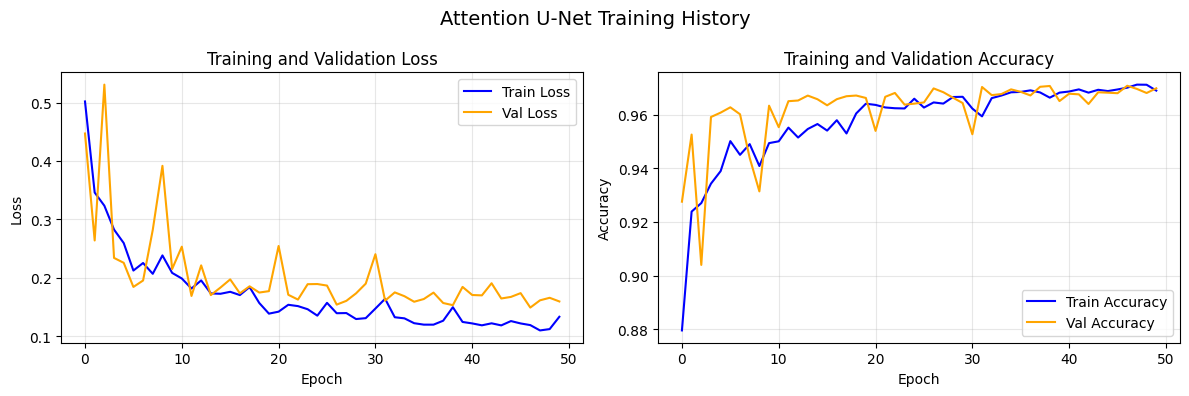

In [46]:
# Plot training history
# Skip if history is empty (when using pre-trained model)
if len(history['train_loss']) == 0:
    print("No training history available (model was loaded from pre-trained weights).")
    print("Skipping training history plots.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
    axes[0].plot(history['val_loss'], label='Val Loss', color='orange')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(history['train_acc'], label='Train Accuracy', color='blue')
    axes[1].plot(history['val_acc'], label='Val Accuracy', color='orange')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('Attention U-Net Training History', fontsize=14)
    plt.tight_layout()
    plt.show()

# 11. Generate Prediction Masks

Apply the trained model to satellite imagery and visualize predicted deforestation masks.

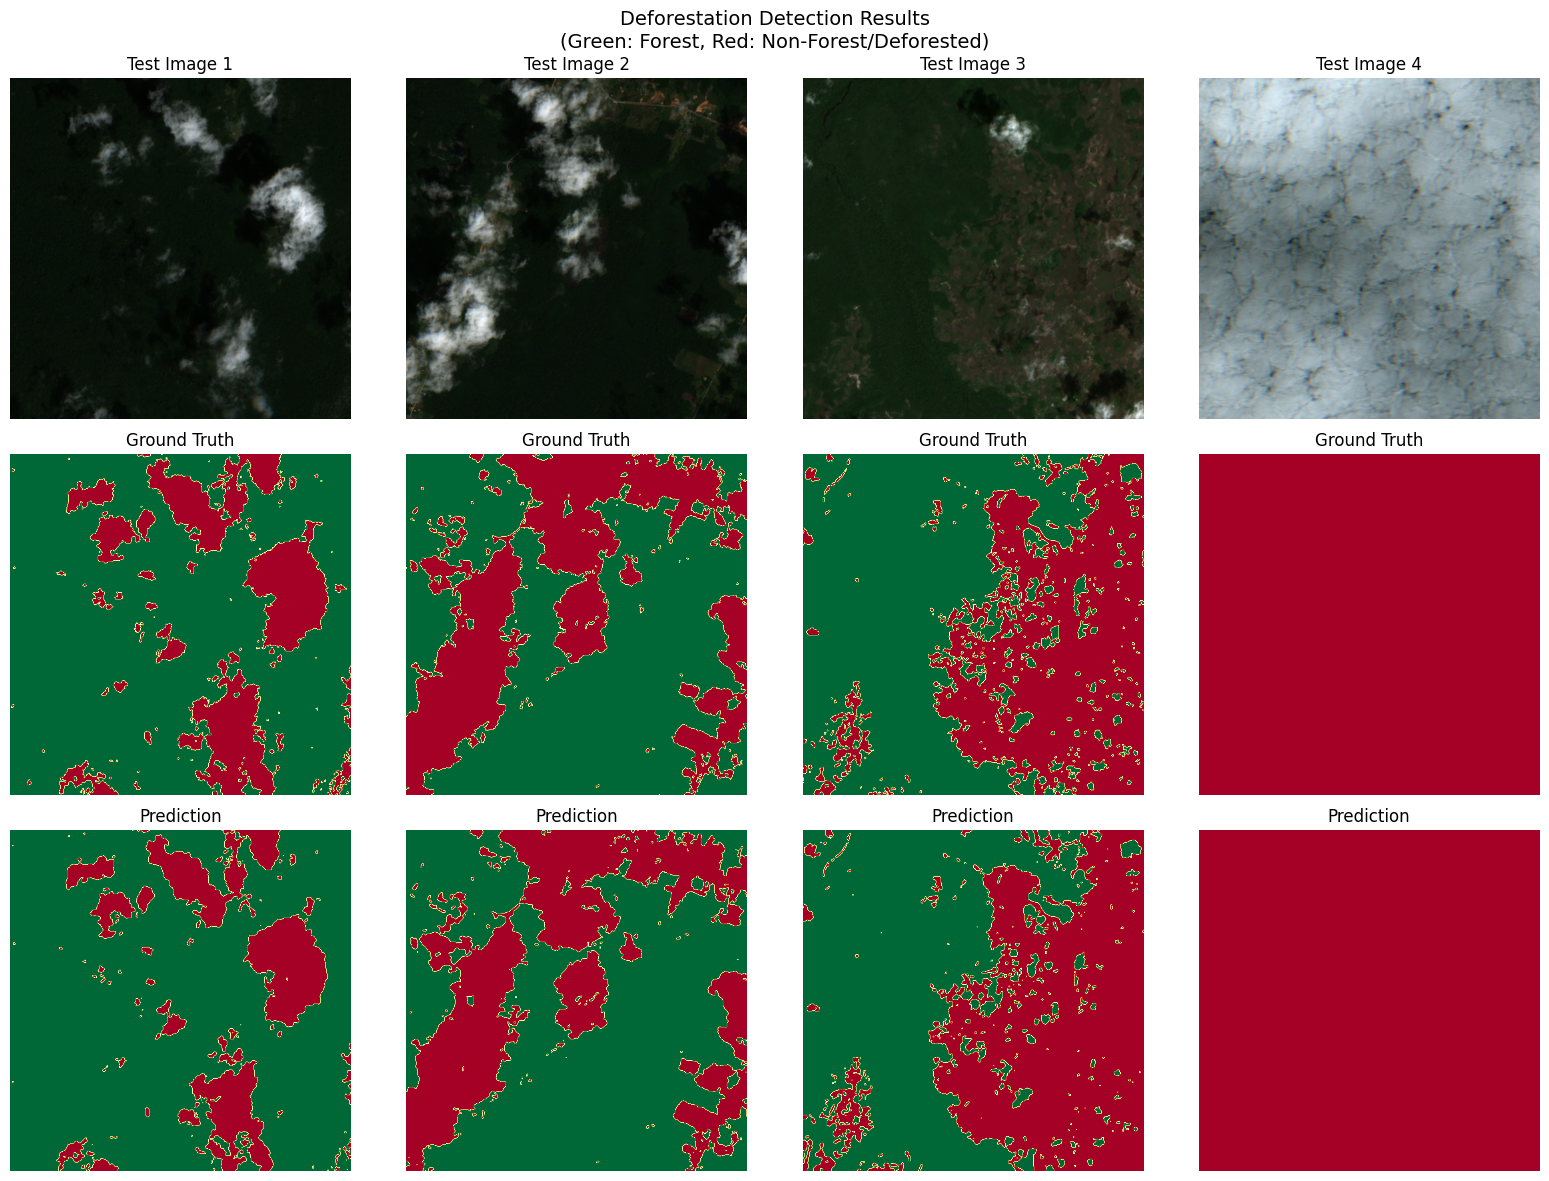

In [47]:
# Generate predictions on test images
model.eval()
n_samples = min(4, len(test_dataset))

fig, axes = plt.subplots(3, n_samples, figsize=(4 * n_samples, 12))

with torch.no_grad():
    for i in range(n_samples):
        img, mask = test_dataset[i]
        img_tensor = img.unsqueeze(0).to(device)
        
        # Get prediction
        pred = model(img_tensor)
        pred_binary = (pred > 0.5).float().cpu().squeeze().numpy()
        
        # Original image (RGB bands - channels 0,1,2)
        img_np = img.numpy()
        rgb = np.transpose(img_np[:3], (1, 2, 0))  # CHW -> HWC
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalize for display
        axes[0, i].imshow(rgb)
        axes[0, i].set_title(f'Test Image {i+1}')
        axes[0, i].axis('off')
        
        # Ground truth mask
        mask_np = mask.squeeze().numpy()
        axes[1, i].imshow(mask_np, cmap='RdYlGn')
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')
        
        # Predicted mask
        axes[2, i].imshow(pred_binary, cmap='RdYlGn')
        axes[2, i].set_title('Prediction')
        axes[2, i].axis('off')

plt.suptitle('Deforestation Detection Results\n(Green: Forest, Red: Non-Forest/Deforested)', fontsize=14)
plt.tight_layout()
plt.show()

## Reproduction Notes:

- Pre-trained models are available in the `models/` directory
- Training from scratch requires approximately 50 epochs with data augmentation
- GPU acceleration is recommended for training

## References:

- Original paper: https://www.sciencedirect.com/science/article/pii/S0303243422000113
- Dataset: https://zenodo.org/record/4498086
- Attention U-Net paper: Oktay et al., 2018

Image shape: (4, 512, 512)
Mask shape: (1, 512, 512)
Image dtype: float32
Image min/max: 0.0000 / 1.0000
Mask unique values: [0. 1.]
Mask class distribution:
  Class 0 (non-forest): 35.31%
  Class 1 (forest):     64.69%


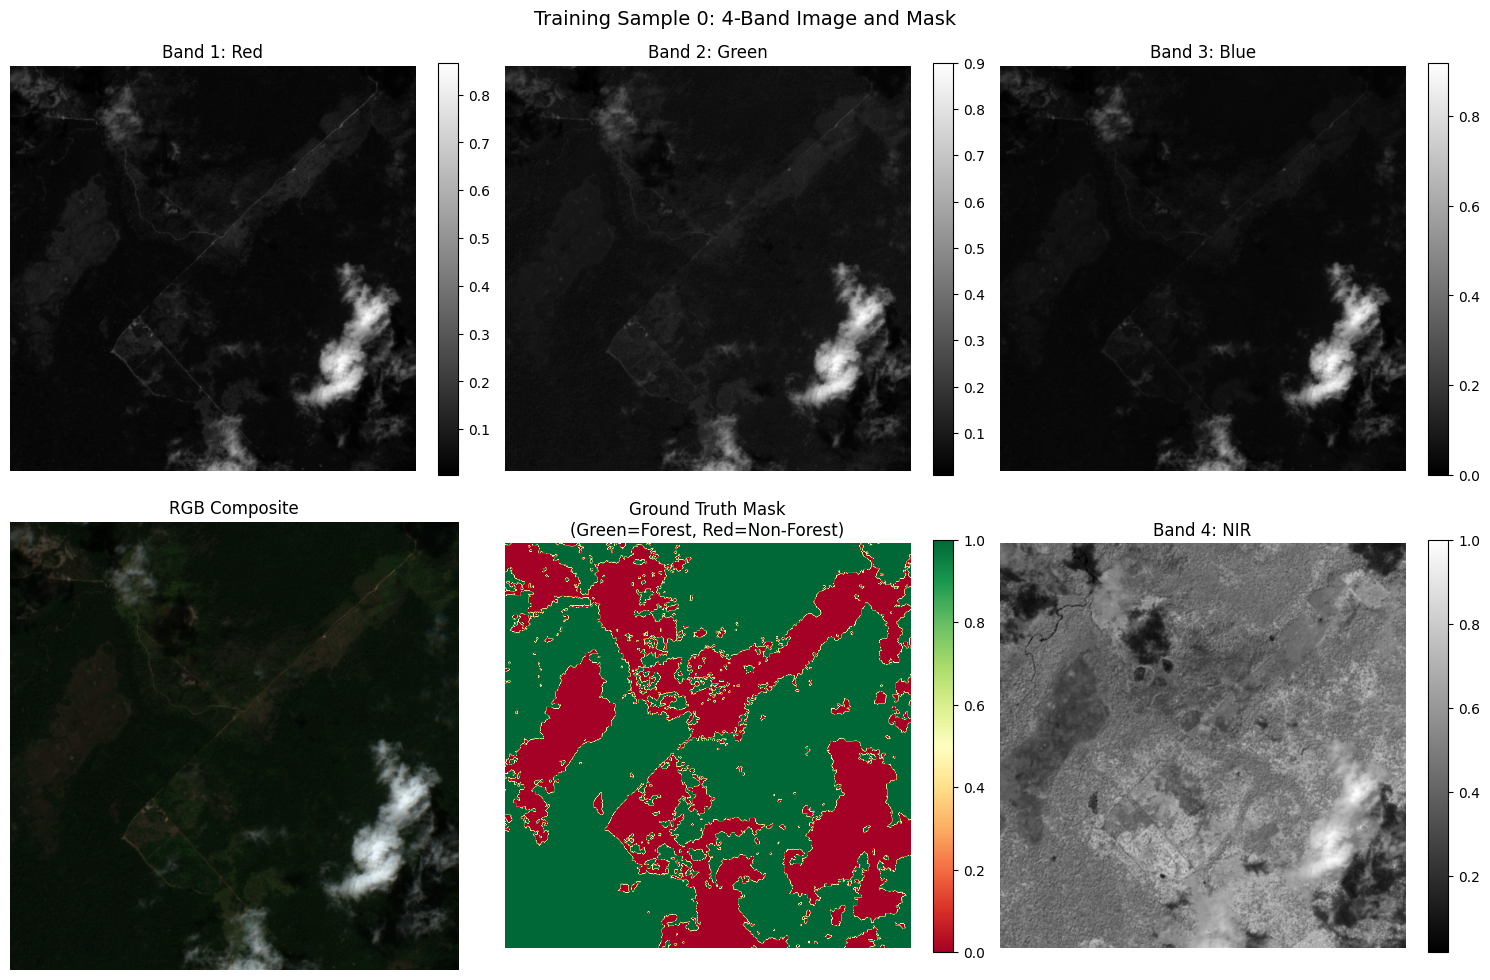

In [48]:
# Visualize a single training example in detail
import matplotlib.pyplot as plt
import numpy as np

# Get one sample from the dataset
idx = 0  # Change this to view different samples
image, mask = train_dataset[idx]

# Convert to numpy
img_np = image.numpy()  # Shape: (4, 512, 512)
mask_np = mask.numpy()  # Shape: (1, 512, 512)

print(f"Image shape: {img_np.shape}")
print(f"Mask shape: {mask_np.shape}")
print(f"Image dtype: {img_np.dtype}")
print(f"Image min/max: {img_np.min():.4f} / {img_np.max():.4f}")
print(f"Mask unique values: {np.unique(mask_np)}")
print(f"Mask class distribution:")
print(f"  Class 0 (non-forest): {(mask_np == 0).sum() / mask_np.size:.2%}")
print(f"  Class 1 (forest):     {(mask_np == 1).sum() / mask_np.size:.2%}")

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Individual bands
band_names = ['Red', 'Green', 'Blue', 'NIR']
for i in range(4):
    ax = axes[0, i] if i < 3 else axes[1, 2]
    band = img_np[i]
    im = ax.imshow(band, cmap='gray')
    ax.set_title(f'Band {i+1}: {band_names[i]}')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)

# RGB composite
rgb = np.transpose(img_np[:3], (1, 2, 0))  # CHW -> HWC
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
axes[1, 0].imshow(rgb)
axes[1, 0].set_title('RGB Composite')
axes[1, 0].axis('off')

# Mask
mask_display = mask_np.squeeze()
im = axes[1, 1].imshow(mask_display, cmap='RdYlGn', vmin=0, vmax=1)
axes[1, 1].set_title('Ground Truth Mask\n(Green=Forest, Red=Non-Forest)')
axes[1, 1].axis('off')
plt.colorbar(im, ax=axes[1, 1], fraction=0.046)

plt.suptitle(f'Training Sample {idx}: 4-Band Image and Mask', fontsize=14)
plt.tight_layout()
plt.show()